In [1]:
from __future__ import unicode_literals

import sys, os
BIN = os.path.expanduser("../../")
sys.path.append(BIN)

import numpy as np
from scipy.constants import m_p, c, e
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools

from test_tools import Machine, generate_objects, BunchTracker, track, compare_traces, compare_projections

from PyHEADTAIL_feedback.feedback import IdealBunchFeedback,IdealSliceFeedback,OneboxFeedback
from PyHEADTAIL_feedback.processors.multiplication import ChargeWeighter
from PyHEADTAIL_feedback.processors.linear_transform import Averager
from PyHEADTAIL_feedback.processors.misc import Bypass

np.random.seed(0)

PyHEADTAIL v(no git available to determine version)




In [2]:
""" 
    This example shows how to use ideal feedback systems in PyHEADTAIL simulations. In order to avoid writing
    unnecessary code here, the used bunch, slicer and transfer maps are created by using functions and classes
    written to file 'test_tools.py' in this folder.
"""

u" \n    This example shows how to use ideal feedback systems in PyHEADTAIL simulations. In order to avoid writing\n    unnecessary code here, the used bunch, slicer and transfer maps are created by using functions and classes\n    written to file 'test_tools.py' in this folder.\n"

In [3]:
# Basic parameters for the simulation
n_macroparticles = 10000
n_slices = 20
n_segments = 5
n_sigma_z = 4 

n_turns = 150

# Longitudinal motion of the bunch is not taken into account in this example.
machine = Machine(Q_s = 0.00000001)
# The longitudinal motion can be included to simulations by uncommenting the following line
# machine = Machine(Q_s = 0.0020443)

bunch_ref, slicer_ref,trans_map, long_map = generate_objects(machine, n_macroparticles,n_segments, 
                                                             n_slices,n_sigma_z)

In [4]:
# This creates an artificially kicked bunch, which will be damped by using different feedback systems

slice_set = bunch_ref.get_slices(slicer_ref, statistics=True)
p_idx = slice_set.particles_within_cuts
s_idx = slice_set.slice_index_of_particle.take(p_idx)

# Random kicks for slices
kick_x = 0.003*(-1.0+2*np.random.rand(n_slices))
kick_y = 0.003*(-1.0+2*np.random.rand(n_slices))

# A bunch kick
# kick_x = 0.003*np.ones(n_slices)
# kick_y = 0.003*np.ones(n_slices)

for p_id, s_id in itertools.izip(p_idx,s_idx):
    bunch_ref.x[p_id] += kick_x[s_id]
    bunch_ref.y[p_id] += kick_y[s_id]
    
bunch_init = copy.deepcopy(bunch_ref)
tracker_ref = BunchTracker(bunch_init)
maps_ref = [i for i in trans_map] + [long_map]
track(n_turns, bunch_init,maps_ref,tracker_ref)

In [5]:
# In the used code, the parameter 'gain' is determined as a fraction of the signal which is bypassed
# perfectly throught the signal processors

# There are two ways to set a gain value. If only one value is given, same value is used both in 
# horizontal and vertical planes. If two values are given, separed values (x,y) are used for horizontal and
# vertical planes.

feedback_gain = 0.1
# feedback_gain = (0.1,0.4)

In [6]:
# The simplest possible feedback is a bunch feedback. It corrects the mean_xp and mean_yp values of the bunch 
# by a fraction of gain.

# The bunch is created by copying the bunch created earlier
bunch_IdealBunchFB = copy.deepcopy(bunch_ref)

# A tracker object from test_tools.py is used for recording the values of the bunch during the simulation
tracker_IdealBunchFB = BunchTracker(bunch_IdealBunchFB)

# The feedback system itself is a PyHEADTAIL map element, which is created by creating IdealBunchFeedback(...) object.
feedback_map = IdealBunchFeedback(feedback_gain)
# The map element is added to the total map for tracking
total_map_FB = [i for i in trans_map] + [long_map] + [feedback_map]

# The actual simulation is performed by calling track method from test_tools.py
track(n_turns, bunch_IdealBunchFB,total_map_FB,tracker_IdealBunchFB)

In [7]:
bunch_IdealSliceFB = copy.deepcopy(bunch_ref)
tracker_IdealSliceFB = BunchTracker(bunch_IdealSliceFB)
slicer_IdealSliceFB = copy.deepcopy(slicer_ref)

# The most idealistic feedback is a slice feedback. It correct the mean_xp and mean_yp of the slices by 
# a fraction of gain

# A map element for the ideal slice feedback is created by creating IdealSliceFeedback(...) object. The object requires
# a PyHEADTAIL slicer object as an input parameter for slicing.
feedback_map = IdealSliceFeedback(feedback_gain,slicer_IdealSliceFB)
total_map_FB = [i for i in trans_map] + [long_map] + [feedback_map]

track(n_turns, bunch_IdealSliceFB,total_map_FB,tracker_IdealSliceFB)

In [8]:
bunch_OneBox_slice = copy.deepcopy(bunch_ref)
tracker_OneBox_slice = BunchTracker(bunch_OneBox_slice)
slicer_OneBox_slice = copy.deepcopy(slicer_ref)

# The examples above utilize separately programmed ideal feedback systems. The actual feedback module is a modular
# systems. The process inside the module can be divided into three steps:
#     1) The mean_xp/mean_yp or mean_x/mean_y values from the slices are taken as an input signal
#     2) The signal is passed through signal processors, which modifyes the signal
#     3) The mean_xp/mean_yp or mean_x/mean_y values of the slices are corrected by a fraction of gain from the signal
#
# The steps 1-3 can be done in one PyHEADTAIL map element by using idealized OneboxFeedback or in separated map elements 
# representing pickups and kickers
#
# In order to demonstrade the concept of the signal processors, the ideal feedback systems are implemented by using 
# OneboxFeedback. The simplest feedback system to implement is the ideal slice feedback:
#
# The signal processors are given to the PyHEADTAIL map element in separate lists for horizontal and vertical planes.
# In the ideal slice feedback, signals go through the signal processors without modifications. Thus, the lists of signal
# processors contain only Bypass() processors.

processors_slice_x = [Bypass()]
processors_slice_y = [Bypass()]

# A PyHEADTAIL map element is created by calling OneboxFeedback(...) object. OneboxFeedback requires a gain
# value, a PyHEADTAIL slicer object and the lists of signal processors for horizontal and vertical planes
# as input parameters
feedback_map = OneboxFeedback(feedback_gain,slicer_OneBox_slice,processors_slice_x,processors_slice_y,axis='displacement')
total_map_OneBox_slice = [i for i in trans_map] + [long_map] + [feedback_map]

track(n_turns, bunch_OneBox_slice,total_map_OneBox_slice,tracker_OneBox_slice)

In [9]:
bunch_OneBox_bunch = copy.deepcopy(bunch_ref)
tracker_OneBox_bunch = BunchTracker(bunch_OneBox_bunch)
slicer_OneBox_bunch = copy.deepcopy(slicer_ref)

# The ideal bunch feedback makes corrections to mean xp/yp values of the bunch. In order to implement this 
# the input signal (mean xp/yp values of the slices) must be modified into the mean xp/yp value of the bunch 
# by using signal processors. The mean xp/yp value of the bunch is a macroparticle count weighted average of
# displacements of the individual slices. This can be implemented by using signal processors ChargeWeighter(...)
# and Averager()

processors_bunch_x = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager()
]
processors_bunch_y = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager()
]

# The code for the PyHEADTAIL map element is indentical to the code written in the previous example

feedback_map = OneboxFeedback(feedback_gain,slicer_OneBox_bunch,processors_bunch_x,processors_bunch_y,axis='displacement')
total_map_OneBox_bunch = [i for i in trans_map] + [long_map] + [feedback_map]

track(n_turns, bunch_OneBox_bunch,total_map_OneBox_bunch,tracker_OneBox_bunch)

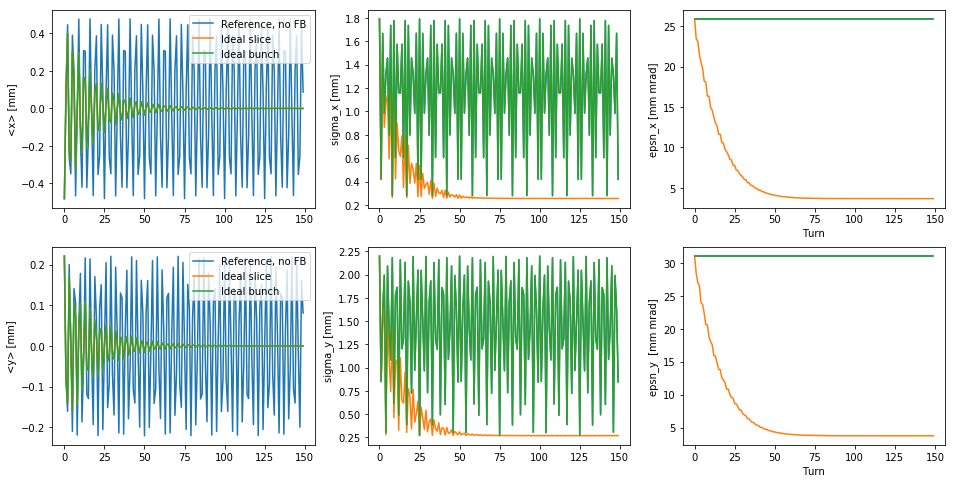

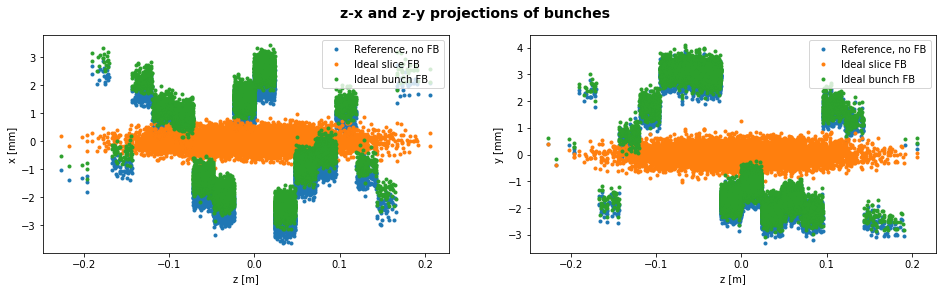

In [10]:
# The traces from the ideal slice and the ideal bunch feedbacks are plotted as well as 
# the particle projections of the bunches after the simulations

compare_traces([tracker_ref,tracker_IdealSliceFB,tracker_IdealBunchFB],
               ['Reference, no FB', 'Ideal slice', 'Ideal bunch'])
compare_projections([bunch_init, bunch_IdealSliceFB, bunch_IdealBunchFB], 
                    ['Reference, no FB', 'Ideal slice FB', 'Ideal bunch FB'])

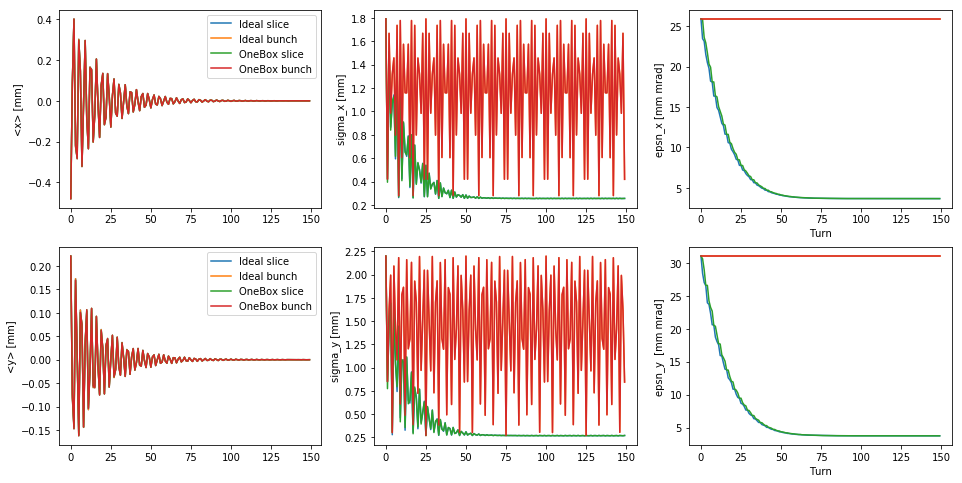

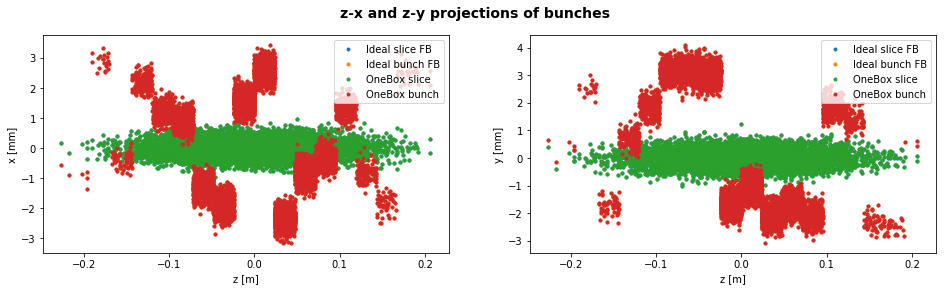

In [11]:
# The traces and particle projections from the ideal slice and the idal bunch feedbacks are compared 
# to the those implemented with OneboxFeedback

compare_traces([tracker_IdealSliceFB,tracker_IdealBunchFB, tracker_OneBox_slice, tracker_OneBox_bunch],
               ['Ideal slice', 'Ideal bunch','OneBox slice', 'OneBox bunch'])
compare_projections([bunch_IdealSliceFB, bunch_IdealBunchFB,bunch_OneBox_slice,bunch_OneBox_bunch], 
                    ['Ideal slice FB', 'Ideal bunch FB','OneBox slice', 'OneBox bunch'])

Jani Komppula, CERN, 2017